<a href="https://colab.research.google.com/github/elenipapadopoulou4/thesis-code/blob/main/AU_Detection_EmotioNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Train RESNET network on EmotioNet dataset for Action Units

The EmotioNet database is annotated with 11 AUs <br>
1: Inner brow raiser  <br>
2: Outer brow raiser  <br>
4: Brow lowerer  <br>
5: Upper lid raiser	 <br>
6: Cheek raiser	 <br>
9: Nose wrinkler	 <br>
12: Lip corner puller  <br>
17: Chin raiser	 <br>
20: Lip stretcher	 <br>
25: Lips part	 <br>
26: Jaw drop	 <br>

In [ ]:
import tensorflow as tf

import os 
import matplotlib.pyplot as plt

import numpy as np
import cv2

import csv

from tensorflow.keras.callbacks import ModelCheckpoint 

import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,GlobalAveragePooling2D

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout

from sklearn.metrics import classification_report, confusion_matrix,recall_score,f1_score,accuracy_score,multilabel_confusion_matrix

import statistics



import matplotlib.image as mpimg

from keras.models import model_from_json
import json

from keras import backend as K


from PIL import Image

from collections import Counter

import joblib
from tabulate import tabulate


In [ ]:
!pip install tensorflow==2.8
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libcudnn8 is already the newest version (8.1.0.77-1+cuda11.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive",force_remount=True)

Mounted at /content/gdrive


In [ ]:
!unzip /content/gdrive/MyDrive/train_net/datasets/emotionet/emotionet_aligned.zip -d /content/emotionet

Streaming output truncated to the last 5000 lines.
  inflating: /content/emotionet/emotionet_aligned/validation/019662.jpg  
  inflating: /content/emotionet/emotionet_aligned/validation/019663.jpg  
  inflating: /content/emotionet/emotionet_aligned/validation/019664.jpg  
  inflating: /content/emotionet/emotionet_aligned/validation/019665.jpg  
  inflating: /content/emotionet/emotionet_aligned/validation/019666.jpg  
  inflating: /content/emotionet/emotionet_aligned/validation/019667.jpg  
  inflating: /content/emotionet/emotionet_aligned/validation/019668.jpg  
  inflating: /content/emotionet/emotionet_aligned/validation/019669.jpg  
  inflating: /content/emotionet/emotionet_aligned/validation/019670.jpg  
  inflating: /content/emotionet/emotionet_aligned/validation/019671.jpg  
  inflating: /content/emotionet/emotionet_aligned/validation/019672.jpg  
  inflating: /content/emotionet/emotionet_aligned/validation/019673.jpg  
  inflating: /content/emotionet/emotionet_aligned/validation/

In [ ]:
os.rename("/content/emotionet/emotionet_aligned","/content/emotionet/emotionet")

In [ ]:
# for emotionet use validation as train and test as validation
dataset_path = '/content/emotionet/emotionet/'
dataset_path_train = '/content/emotionet/emotionet/validation'
dataset_path_val = '/content/emotionet/emotionet/test'
ff_outputs_train =  '/content/gdrive/MyDrive/train_net/FairFace/EmotioNet_validation_outputs.csv'
ff_outputs_val = '/content/gdrive/MyDrive/train_net/FairFace/EmotioNet_test_outputs.csv'

## EmotioNet Fair Face outputs

Training

In [ ]:
df_ff_train =  pd.read_csv(ff_outputs_train,header=0)

In [ ]:
#avoid double values  
#rename image path

train_names_ff =[] #list with all names of images
for i, row in df_ff_train.iterrows():
  path = df_ff_train['face_name_align'][i]
  image_name = (path[path.rfind('/')+1:path.rfind('face')-1]).rjust(6, '0')+'.jpg'
  if image_name in train_names_ff:
    df_ff_train.drop([i], axis=0, inplace=True)
  else:
    df_ff_train['face_name_align'][i] = os.path.join(dataset_path_train,image_name)
    train_names_ff.append(image_name)


In [ ]:
df_ff_train = df_ff_train.drop(['race','race_scores_fair','race_scores_fair_4','gender_scores_fair','age_scores_fair'],axis=1)
df_ff_train = df_ff_train.rename(columns={"race4": "race"})

In [ ]:
df_ff_train

,face_name_align,race,gender,age
0,/content/emotionet/emotionet/validation/000001...,White,Female,20-29
1,/content/emotionet/emotionet/validation/000010...,White,Male,40-49
2,/content/emotionet/emotionet/validation/000100...,Asian,Female,20-29
3,/content/emotionet/emotionet/validation/001000...,White,Male,50-59
4,/content/emotionet/emotionet/validation/010000...,White,Male,50-59
...,...,...,...,...
25704,/content/emotionet/emotionet/validation/009995...,White,Female,20-29
25705,/content/emotionet/emotionet/validation/009996...,White,Male,40-49
25707,/content/emotionet/emotionet/validation/009997...,White,Female,30-39
25708,/content/emotionet/emotionet/validation/009998...,White,Male,60-69


Validation

In [ ]:
df_ff_val =  pd.read_csv(ff_outputs_val,header=0)

In [ ]:
#avoid double values  
#rename image path

val_names_ff =[] #list with all names of images
for i, row in df_ff_val.iterrows():
  path = df_ff_val['face_name_align'][i]
  image_name = (path[path.rfind('/')+1:path.rfind('face')-1])+'.jpg'
  if image_name in val_names_ff:
    df_ff_val.drop([i], axis=0, inplace=True)
  else:
    df_ff_val['face_name_align'][i] = os.path.join(dataset_path_val,image_name)
    val_names_ff.append(image_name)


In [ ]:
df_ff_val = df_ff_val.drop(['race','race_scores_fair','race_scores_fair_4','gender_scores_fair','age_scores_fair'],axis=1)
df_ff_val = df_ff_val.rename(columns={"race4": "race"})

In [ ]:
df_ff_val

,face_name_align,race,gender,age
0,/content/emotionet/emotionet/test/au_image_1.jpg,White,Male,10-19
1,/content/emotionet/emotionet/test/au_image_10.jpg,White,Male,60-69
2,/content/emotionet/emotionet/test/au_image_100...,White,Male,30-39
3,/content/emotionet/emotionet/test/au_image_100...,White,Male,40-49
4,/content/emotionet/emotionet/test/au_image_100...,White,Female,3-9
...,...,...,...,...
21307,/content/emotionet/emotionet/test/au_image_999...,White,Female,20-29
21308,/content/emotionet/emotionet/test/au_image_999...,White,Female,20-29
21309,/content/emotionet/emotionet/test/au_image_999...,White,Female,20-29
21310,/content/emotionet/emotionet/test/au_image_999...,White,Female,10-19


## create dataframe


In [ ]:
#training set
# read annotations txt and convert to pandas dataframe
df_train_first =  pd.read_csv(os.path.join(dataset_path,'emotionet_valid.txt'),sep=" ",header=None)
#remove last 2 columns (not needed)
df_train_first.drop(df_train_first.columns[len(df_train_first.columns)-1], axis=1, inplace=True)
df_train_first.drop(df_train_first.columns[len(df_train_first.columns)-1], axis=1, inplace=True)
# create absolute paths
df_train_first[0] = '/content/emotionet/'+ df_train_first[0]
#rename path column
df_train_first = df_train_first.rename(columns={0: "face_name_align"})


In [ ]:
df_train_first

,face_name_align,1,2,3,4,5,6,7,8,9,10,11
0,/content/emotionet/emotionet/validation/000001...,0,0,0,1,0,0,1,0,0,1,0
1,/content/emotionet/emotionet/validation/000002...,0,-1,1,0,0,0,0,0,0,0,1
2,/content/emotionet/emotionet/validation/000003...,0,0,0,0,0,0,0,0,0,0,1
3,/content/emotionet/emotionet/validation/000004...,1,0,1,1,0,0,1,0,0,0,0
4,/content/emotionet/emotionet/validation/000005...,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
24639,/content/emotionet/emotionet/validation/024661...,0,0,0,1,0,0,1,0,0,1,1
24640,/content/emotionet/emotionet/validation/024662...,0,0,0,0,0,-1,-1,0,0,1,0
24641,/content/emotionet/emotionet/validation/024663...,0,0,0,0,0,0,0,0,0,1,0
24642,/content/emotionet/emotionet/validation/024664...,0,0,0,0,0,0,-1,0,0,-1,0


In [ ]:
#validation set
df_val_first =  pd.read_csv(os.path.join(dataset_path,'emotionet_test.txt'),sep=" ",header=None)
# create absolute paths
df_val_first[0] = '/content/emotionet/'+df_val_first[0]
#rename path column
df_val_first = df_val_first.rename(columns={0: "face_name_align"})

In [ ]:
df_val_first

,face_name_align,1,2,3,4,5,6,7,8,9,10,11
0,/content/emotionet/emotionet/test/au_image_1.jpg,0,0,0,0,0,0,0,0,0,0,0
1,/content/emotionet/emotionet/test/au_image_2.jpg,0,0,0,0,0,0,0,0,0,1,0
2,/content/emotionet/emotionet/test/au_image_3.jpg,0,0,0,0,0,0,0,0,0,0,0
3,/content/emotionet/emotionet/test/au_image_4.jpg,0,0,0,0,0,0,0,0,0,0,0
4,/content/emotionet/emotionet/test/au_image_5.jpg,0,0,0,0,1,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
20356,/content/emotionet/emotionet/test/au_image_203...,0,0,-1,0,0,0,0,0,0,0,0
20357,/content/emotionet/emotionet/test/au_image_203...,0,0,-1,0,1,0,1,0,0,1,0
20358,/content/emotionet/emotionet/test/au_image_203...,1,0,-1,1,0,0,1,0,0,1,1
20359,/content/emotionet/emotionet/test/au_image_203...,0,0,-1,0,1,0,1,0,0,1,0


GET FF VALUES TO DATAFRAME


In [ ]:
df_train = (pd.merge(df_train_first, df_ff_train, on='face_name_align'))
df_val = (pd.merge(df_val_first, df_ff_val, on='face_name_align'))
print("lenght of train",len(df_train))
print("lenght of validation",len(df_val))

lenght of train 24620
lenght of validation 20346


In [ ]:
#drop some rows to have samplesMODbatch==0
df_train.drop(df_train.index[0:12], axis=0, inplace=True)
df_val.drop(df_val.index[0:26], axis=0, inplace=True)

In [ ]:
df_train

,face_name_align,1,2,3,4,5,6,7,8,9,10,11,race,gender,age
12,/content/emotionet/emotionet/validation/000013...,0,0,0,-1,1,0,1,0,0,1,0,White,Female,20-29
13,/content/emotionet/emotionet/validation/000014...,0,0,-1,-1,0,0,0,0,0,-1,0,Asian,Female,20-29
14,/content/emotionet/emotionet/validation/000015...,0,-1,0,-1,0,0,0,1,0,0,-1,Indian,Female,20-29
15,/content/emotionet/emotionet/validation/000016...,-1,1,0,1,0,0,0,0,0,0,0,Asian,Female,20-29
16,/content/emotionet/emotionet/validation/000017...,0,-1,0,-1,0,0,0,0,0,0,0,Black,Male,30-39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24615,/content/emotionet/emotionet/validation/024661...,0,0,0,1,0,0,1,0,0,1,1,White,Female,20-29
24616,/content/emotionet/emotionet/validation/024662...,0,0,0,0,0,-1,-1,0,0,1,0,White,Male,30-39
24617,/content/emotionet/emotionet/validation/024663...,0,0,0,0,0,0,0,0,0,1,0,White,Female,20-29
24618,/content/emotionet/emotionet/validation/024664...,0,0,0,0,0,0,-1,0,0,-1,0,White,Male,20-29


In [ ]:
df_val

,face_name_align,1,2,3,4,5,6,7,8,9,10,11,race,gender,age
26,/content/emotionet/emotionet/test/au_image_27.jpg,0,0,0,0,1,0,1,0,0,1,0,White,Female,30-39
27,/content/emotionet/emotionet/test/au_image_28.jpg,0,0,0,0,0,0,0,0,0,0,0,White,Female,20-29
28,/content/emotionet/emotionet/test/au_image_29.jpg,0,0,0,0,0,0,0,0,0,1,1,White,Female,30-39
29,/content/emotionet/emotionet/test/au_image_30.jpg,0,0,0,0,0,0,0,0,0,1,0,White,Female,20-29
30,/content/emotionet/emotionet/test/au_image_31.jpg,0,0,0,0,0,0,0,0,0,0,0,White,Female,50-59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20341,/content/emotionet/emotionet/test/au_image_203...,0,0,-1,0,0,0,0,0,0,0,0,Indian,Male,10-19
20342,/content/emotionet/emotionet/test/au_image_203...,0,0,-1,0,1,0,1,0,0,1,0,Indian,Female,30-39
20343,/content/emotionet/emotionet/test/au_image_203...,1,0,-1,1,0,0,1,0,0,1,1,Asian,Female,20-29
20344,/content/emotionet/emotionet/test/au_image_203...,0,0,-1,0,1,0,1,0,0,1,0,White,Male,30-39


# before split

##Show data

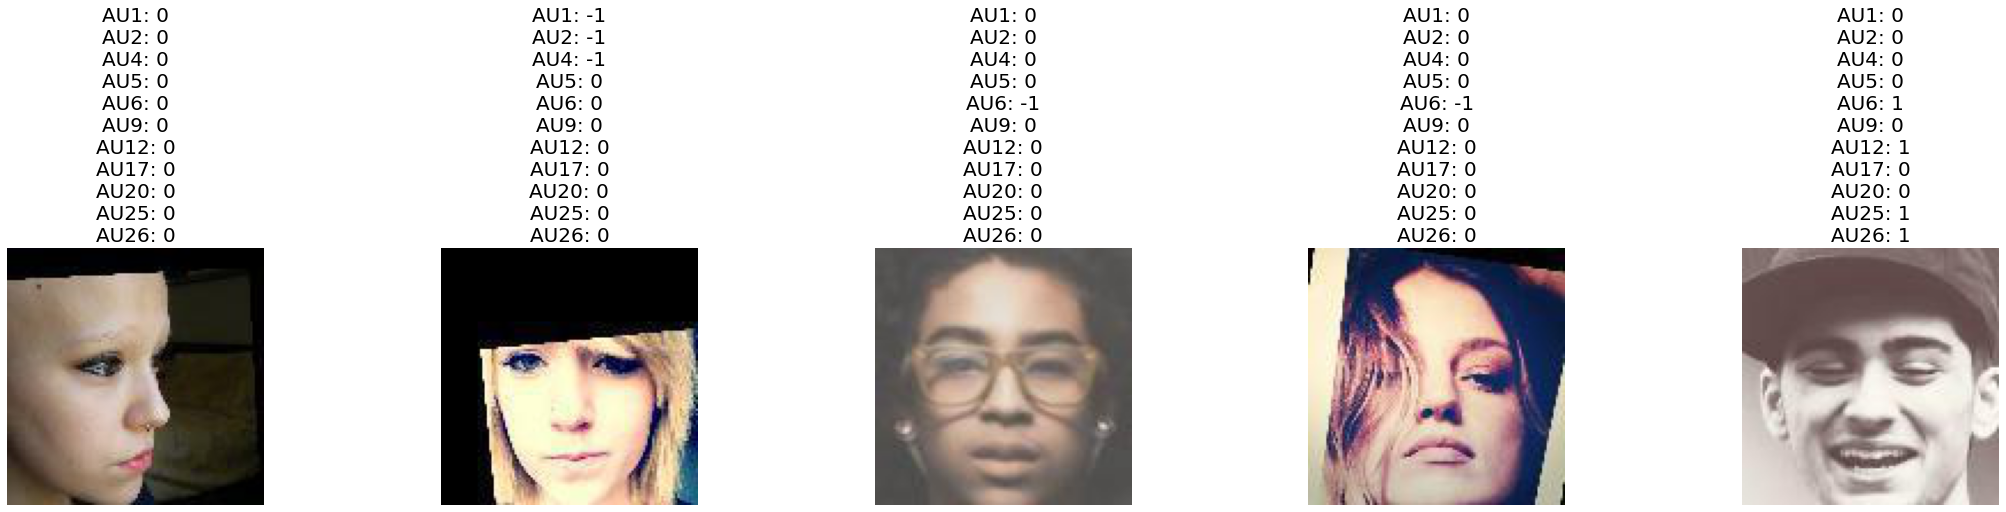

In [ ]:
num_images = 5
fig, axs = plt.subplots(figsize=(30, 7), ncols=num_images, constrained_layout=True)
for i in range(num_images):
  index = i+30
  image  =  mpimg.imread(df_train['face_name_align'][index])
  axs[i].imshow(image)  
  axs[i].set_title('AU1: {}\nAU2: {}\nAU4: {}\nAU5: {}\nAU6: {}\nAU9: {}\nAU12: {}\nAU17: {}\nAU20: {}\nAU25: {}\nAU26: {}'.format(
      df_train[1][index],df_train[2][index],df_train[3][index],df_train[4][index],df_train[5][index],df_train[6][index],
      df_train[7][index],df_train[8][index],df_train[9][index],df_train[10][index],df_train[11][index]),fontsize = 20)
  axs[i].axis("off")

## data preprocessing 

In [ ]:
# load one image
image = Image.open(df_train['face_name_align'][12332])
# convert image to numpy array
data = np.asarray(image)

In [ ]:
print(np.shape(data))

(112, 112, 3)


Οι εικόνες που στέλνουμε στο νευρωνικό δίκτυο είναι resized σε 112*112 και είναι έγχρωμες (τιμές απο 0-255). <br>
 Έτσι στο δίκτυο οι πίνακες είναι μεγέθους 112 * 112 * 3. 

In [ ]:
# get batches of tensor image data (rescaled to 0-1)
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
    df_train,
    x_col='face_name_align',
    y_col=[1,2,3,4,5,6,7,8,9,10,11],
    target_size=(112, 112),
    color_mode='rgb',
    class_mode='raw', #multilabel output numpy array of values in y_col column(s),
    batch_size=batch_size 
  )

validation_generator = test_datagen.flow_from_dataframe(
    df_val,
    x_col="face_name_align",
    y_col=[1,2,3,4,5,6,7,8,9,10,11],
    target_size=(112, 112),
    color_mode='rgb',
    class_mode='raw',
    batch_size=batch_size
  )


Found 24608 validated image filenames.
Found 20320 validated image filenames.


## Class distribution

In [ ]:
print("Actiavated AU ratio for all sets")
data = []
ratio_train = []
ratio_val = []
aus = []
tv_diff = []
for au in range(1,12):  
  aus.append(au)   
  r_train = len(df_train[df_train[au]==1])/(len(df_train)-len(df_train[df_train[au]==-1]))
  r_val = len(df_val[df_val[au]==1])/(len(df_val)-len(df_val[df_val[au]==-1]))
  ratio_train.append(r_train)
  ratio_val.append(r_val)

  tv_diff.append(np.round(np.sum(np.square(r_train - r_val)),4))

table = zip(aus,ratio_train, ratio_val,tv_diff)
print(tabulate(table, headers=['AUs','train ratio','validation ratio','train-val distance'], floatfmt=".4f"))

Actiavated AU ratio for all sets
  AUs    train ratio    validation ratio    train-val distance
-----  -------------  ------------------  --------------------
    1         0.0632              0.0591                0.0000
    2         0.0298              0.0424                0.0002
    3         0.1189              0.0658                0.0028
    4         0.0377              0.0643                0.0007
    5         0.1962              0.2403                0.0019
    6         0.0213              0.0070                0.0002
    7         0.3822              0.4002                0.0003
    8         0.0215              0.0092                0.0002
    9         0.0055              0.0072                0.0000
   10         0.4939              0.4759                0.0003
   11         0.0866              0.0884                0.0000


In [ ]:
def plot_samples(category_name,names,counter_train,counter_val):
  f, axs = plt.subplots(2,2,figsize=(16,5))
  plt.subplot(1, 2, 1) # row 1, col 2 index 1
  plt.bar(names,counter_train,color='c',  edgecolor='black')
  plt.xticks(fontsize=14)
  plt.yticks(fontsize=14)
  plt.title("{} for train set".format(category_name),fontsize=15)

  plt.subplot(1, 2, 2) # row 1, col 2 index 1
  plt.bar(names,counter_val,color='c',  edgecolor='black')
  plt.xticks(fontsize=14)
  plt.yticks(fontsize=14)
  plt.title("{} for validation set".format(category_name),fontsize=15)
  plt.show()


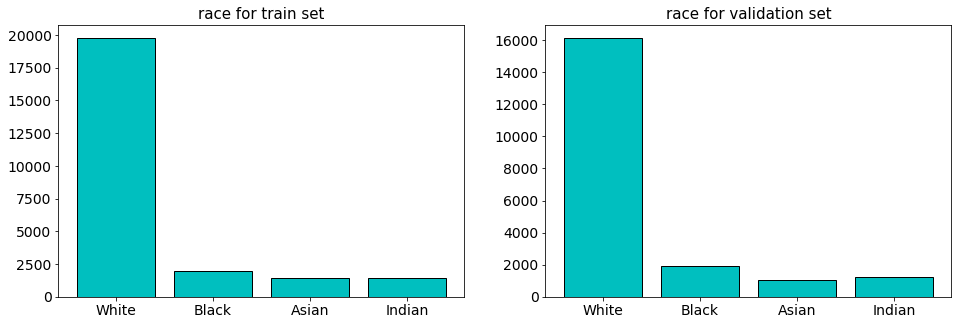

In [ ]:
race_names = ['White','Black','Asian','Indian']

race_counter_train = []
for i in range(len(race_names)):
  race_counter_train.append(len(df_train[df_train['race']==race_names[i]]))

race_counter_val = []
for i in range(len(race_names)):
  race_counter_val.append(len(df_val[df_val['race']==race_names[i]]))

plot_samples('race',race_names,race_counter_train,race_counter_val)


In [ ]:
print(race_counter_train)
print(race_counter_val)

[19777, 1979, 1410, 1442]
[16132, 1935, 1043, 1210]


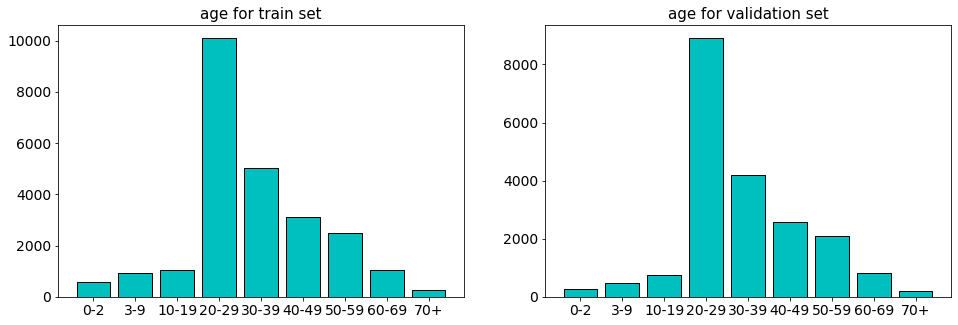

In [ ]:
age_names = ['0-2','3-9','10-19','20-29','30-39','40-49','50-59','60-69','70+']

age_counter_train = []
for i in range(len(age_names)):
  age_counter_train.append(len(df_train[df_train['age']==age_names[i]]))

age_counter_val = []
for i in range(len(age_names)):
  age_counter_val.append(len(df_val[df_val['age']==age_names[i]]))

plot_samples('age',age_names,age_counter_train,age_counter_val)


In [ ]:
print(age_counter_train)
print(age_counter_val)

[583, 939, 1047, 10101, 5026, 3128, 2484, 1041, 259]
[262, 488, 754, 8912, 4206, 2581, 2093, 834, 190]


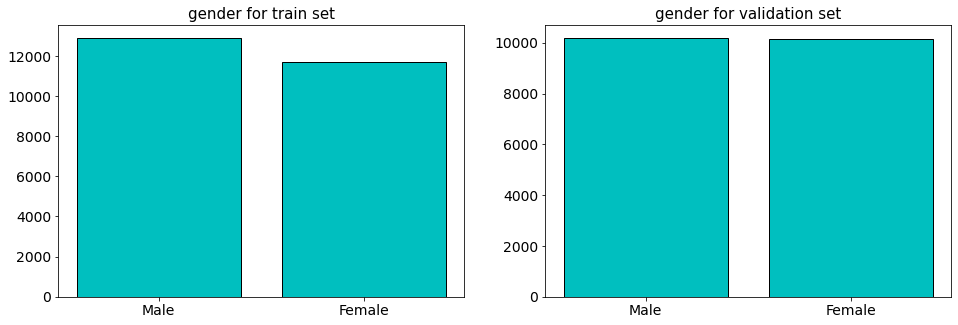

In [ ]:
gender_names = ['Male','Female']

gender_counter_train = []
for i in range(len(gender_names)):
  gender_counter_train.append(len(df_train[df_train['gender']==gender_names[i]]))

gender_counter_val = []
for i in range(len(gender_names)):
  gender_counter_val.append(len(df_val[df_val['gender']==gender_names[i]]))
plot_samples('gender',gender_names,gender_counter_train,gender_counter_val)


In [ ]:
print(gender_counter_train)
print(gender_counter_val)

[12892, 11716]
[10188, 10132]


## training

Multilabel binary classification problem <br>
 

Οι επισημάνσεις για κάθε action unit μπορούν να πάρουν 3 τιμές: <br>
 0: AU not activated<br>
 1: AU activated<br>
-1: Unknown<br>

Αν ένα action unit έχει label = -1 πρέπει να αγνοείται το label και το αντίστοιχο prediction στον υπολογισμό του loss.

In [ ]:
def custom_loss_function(y_true, y_pred):
  au_loss = 0.
  for i in range(batch_size):
    pr = y_pred[i]
    lb = tf.cast(y_true[i],tf.float32)
    con = tf.greater(lb,-0.5)
    label_keep = tf.cast(tf.boolean_mask(lb,con),tf.float32)
    pr_keep = tf.boolean_mask(pr,con)
    #tf.print(pr_keep)
    au_loss +=  tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=label_keep,logits=pr_keep))/batch_size
  return(au_loss)

In [ ]:
#our model
resnet_model = Sequential()

#pretrained model
pretrained_model= tf.keras.applications.ResNet50(
    include_top=False, #custume input and output layers based on our data
    weights="imagenet", #use weights from imagenet training 
    input_tensor=None,
    input_shape=(112,112,3),
    pooling='avg' , #average
)
     
resnet_model.add(pretrained_model)

In [ ]:
# see layers of resnet 50
#pretrained_model.summary()

In [ ]:
#resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(11, activation='sigmoid'))


In [ ]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_1 (Dense)             (None, 11)                22539     
                                                                 
Total params: 23,610,251
Trainable params: 23,557,131
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
#compile model
resnet_model.compile(optimizer=Adam(learning_rate=0.0001),
                     loss= custom_loss_function)



In [ ]:
#checkpoint 
filepath = "/content/gdrive/MyDrive/train_net/ckp_models/EmotioNet/Emotionet_simple_lr4_NO/EmotioNet_before/EmotioNet-{epoch:02d}.h5"
checkpoint = ModelCheckpoint(  
    filepath,
    monitor="val_loss",
    verbose=1,
    save_best_only=False,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch")

callbacks_list = [checkpoint]


#fit model
history = resnet_model.fit(train_generator,validation_data=validation_generator,epochs=10,callbacks=callbacks_list)


Epoch 1/10
769/769 [==============================] - ETA: 0s - loss: 0.6766
Epoch 1: saving model to /content/gdrive/MyDrive/train_net/ckp_models/EmotioNet/Emotionet_simple_lr4_NO/EmotioNet_before/EmotioNet-01.h5
769/769 [==============================] - 139s 165ms/step - loss: 0.6766 - val_loss: 0.6732
Epoch 2/10
769/769 [==============================] - ETA: 0s - loss: 0.6707
Epoch 2: saving model to /content/gdrive/MyDrive/train_net/ckp_models/EmotioNet/Emotionet_simple_lr4_NO/EmotioNet_before/EmotioNet-02.h5
769/769 [==============================] - 123s 160ms/step - loss: 0.6707 - val_loss: 0.6657
Epoch 3/10
769/769 [==============================] - ETA: 0s - loss: 0.6692
Epoch 3: saving model to /content/gdrive/MyDrive/train_net/ckp_models/EmotioNet/Emotionet_simple_lr4_NO/EmotioNet_before/EmotioNet-03.h5
769/769 [==============================] - 123s 160ms/step - loss: 0.6692 - val_loss: 0.6656
Epoch 4/10
769/769 [==============================] - ETA: 0s - loss: 0.6687
Ep

## evaluation & threshold
 

In [ ]:
batch_size = 32
test_generator = test_datagen.flow_from_dataframe(
    df_val,
    x_col="face_name_align",
    y_col=[1,2,3,4,5,6,7,8,9,10,11],
    target_size=(112, 112),
    color_mode='rgb',
    class_mode='raw',
    batch_size=batch_size,
    shuffle = False
  )


Found 20320 validated image filenames.


In [ ]:
#return list of predictions based on threshold
def threshold_predictions(predictions,thr):
  y_pred = [1 if i>=thr else 0 for i in predictions]
  return y_pred
  

In [ ]:
# calculates transformed predictions and returns mean of macro f1 score for all labels/prediction sets 
def macro_f1(labels,predictions,thr):
  predictions_thr =threshold_predictions(predictions,thr)
  f1 = f1_score(labels,predictions_thr,average='binary')
  return f1


In [ ]:
# calculates each f1 & returns mean of all 11 f1 scores
def mean_macro_f1(aus_labels,aus_predictions,thr):
  f1_all = []
  if print==True: print("f1 score for each AU")
  for au in range(1,12):
    f1 = macro_f1(aus_labels[au],aus_predictions[au],thr)
    #print('AU {} --> F1 {} '.format(au, f1))
    f1_all.append(f1)
  #print("mean f1 score for all AUs:",statistics.mean(f1_all))
  return (statistics.mean(f1_all))


In [ ]:
# dictionaries with keys   -- > AUs (11)
#                   values -- > labels/predictions of AU (len(test_images))

def labels_predictions_aus(labels,predictions):
  aus_labels = {k: [] for k in range(1,12)}
  aus_predictions =  {k: [] for k in range(1,12)}

  for l,p in zip(labels,predictions):
    for au in range(1,12):
      if (l[au-1])!= -1:
        aus_labels[au].append(l[au-1])
        aus_predictions[au].append(p[au-1])
  return(aus_labels,aus_predictions)




In [ ]:
# return labels and predictions for each category
def labels_predictions__category(df_test,test_generator,labels,predictions,category_list,category_name):
  labels_cat = {key: [] for key in category_list}
  predictions_cat = {key: [] for key in category_list}
  category_counter = {key: [] for key in category_list} # values are list of indexes of each category

  for i,name in enumerate(test_generator.filenames):  
    category_filename = df_test.loc[df_test['face_name_align'] == name, category_name].item()
    for cat in category_list:
      if category_filename == cat:
          category_counter[cat].append(i)
          labels_cat[cat].append(labels[i])
          predictions_cat[cat].append(predictions[i])
        
    
  return labels_cat,predictions_cat,category_counter

In [ ]:

# calculates and shows results
def results_category(split,category_list,category_name,y_true,y_pred,thr,category_counter):
  print("{} scores {} split".format(category_name,split))
  data = []
  for cat in category_list:
    aus_labels_cat,aus_predictions_cat = labels_predictions_aus(y_true[cat],y_pred[cat])
    data.append([cat,len(category_counter[cat]), mean_macro_f1(aus_labels_cat,aus_predictions_cat,thr)])
  print(tabulate(data, headers=[category_name,"#images" ,"mean binary f1 score"]))
  print()



In [ ]:
models_labels = {}
models_predictions = {}
models_directory = '/content/gdrive/MyDrive/train_net/ckp_models/EmotioNet/Emotionet_simple_lr4_NO/EmotioNet_before'
for saved_model in (os.listdir(models_directory)):
  print(saved_model)
  model = tf.keras.models.load_model(os.path.join(models_directory,saved_model),custom_objects={'custom_loss_function':custom_loss_function})
  models_labels[saved_model[:-3]] = test_generator.labels
  models_predictions[saved_model[:-3]] = model.predict(test_generator)


EmotioNet-01.h5
EmotioNet-02.h5
EmotioNet-03.h5
EmotioNet-04.h5
EmotioNet-05.h5
EmotioNet-06.h5
EmotioNet-07.h5
EmotioNet-08.h5
EmotioNet-09.h5
EmotioNet-10.h5


In [ ]:
for model_name in models_labels.keys():
  aus_labels,aus_predictions = labels_predictions_aus(models_labels[model_name],models_predictions[model_name])
  print("Model Name: =",model_name)
  for thr in np.arange(0,1.1,0.1):
    mean_f1 = mean_macro_f1(aus_labels,aus_predictions,thr)
    print(" Threshold: {} F1 score: {}".format(np.round(thr,2),np.round(mean_f1,4)))


Model Name: = EmotioNet-01
 Threshold: 0.0 F1 score: 0.2046
 Threshold: 0.1 F1 score: 0.196
 Threshold: 0.2 F1 score: 0.195
 Threshold: 0.3 F1 score: 0.1942
 Threshold: 0.4 F1 score: 0.1935
 Threshold: 0.5 F1 score: 0.1929
 Threshold: 0.6 F1 score: 0.1924
 Threshold: 0.7 F1 score: 0.1917
 Threshold: 0.8 F1 score: 0.1907
 Threshold: 0.9 F1 score: 0.1892
 Threshold: 1.0 F1 score: 0.0645
Model Name: = EmotioNet-02
 Threshold: 0.0 F1 score: 0.2046
 Threshold: 0.1 F1 score: 0.2361
 Threshold: 0.2 F1 score: 0.2359
 Threshold: 0.3 F1 score: 0.2358
 Threshold: 0.4 F1 score: 0.2356
 Threshold: 0.5 F1 score: 0.2356
 Threshold: 0.6 F1 score: 0.2355
 Threshold: 0.7 F1 score: 0.2354
 Threshold: 0.8 F1 score: 0.2354
 Threshold: 0.9 F1 score: 0.2351
 Threshold: 1.0 F1 score: 0.2036
Model Name: = EmotioNet-03
 Threshold: 0.0 F1 score: 0.2046
 Threshold: 0.1 F1 score: 0.2288
 Threshold: 0.2 F1 score: 0.228
 Threshold: 0.3 F1 score: 0.2275
 Threshold: 0.4 F1 score: 0.2268
 Threshold: 0.5 F1 score: 0.226

In [ ]:
best_model_name = 'EmotioNet-02'
best_model = tf.keras.models.load_model(os.path.join(models_directory,"{}.h5".format(best_model_name)),custom_objects={'custom_loss_function':custom_loss_function})
best_threshold = 0.1

In [ ]:
# labels&predictions for each category
RACES =['White','Black','Asian','Indian']
y_true_race,y_pred_race,counter_race = labels_predictions__category(df_val,test_generator,models_labels[best_model_name],models_predictions[best_model_name],RACES,'race')

GENDERS = ['Male','Female']
y_true_gender,y_pred_gender,counter_gender = labels_predictions__category(df_val,test_generator,models_labels[best_model_name],models_predictions[best_model_name],GENDERS,'gender')

AGES = ['0-2','3-9','10-19','20-29','30-39','40-49','50-59','60-69','70+']
y_true_age,y_pred_age,counter_age = labels_predictions__category(df_val,test_generator,models_labels[best_model_name],models_predictions[best_model_name],AGES,'age')



In [ ]:
import warnings
warnings.filterwarnings("ignore") 

In [ ]:
print("EmotioNet")
print("NO aug")
print("BEFORE split")
aus_labels_best, aus_predictions_best = labels_predictions_aus(models_labels[best_model_name],models_predictions[best_model_name])
data = [[mean_macro_f1(aus_labels_best,aus_predictions_best,best_threshold)]]
print(tabulate(data, headers=[" macro f1 score"]))
print()
results_category('before',RACES,'race',y_true_race,y_pred_race,best_threshold,counter_race)
results_category('before',GENDERS,'gender',y_true_gender,y_pred_gender,best_threshold,counter_gender)
results_category('before',AGES,'age',y_true_age,y_pred_age,best_threshold,counter_age)


EmotioNet
NO aug
BEFORE split
   macro f1 score
-----------------
         0.236084

race scores before split
race      #images    mean binary f1 score
------  ---------  ----------------------
White       16132                0.236005
Black        1935                0.241516
Asian        1043                0.231152
Indian       1210                0.232917

gender scores before split
gender      #images    mean binary f1 score
--------  ---------  ----------------------
Male          10188                0.231845
Female        10132                0.238957

age scores before split
age      #images    mean binary f1 score
-----  ---------  ----------------------
0-2          262                0.196924
3-9          488                0.23431
10-19        754                0.231104
20-29       8912                0.235805
30-39       4206                0.239478
40-49       2581                0.238818
50-59       2093                0.235525
60-69        834                0.224222


## Visualize predictions

In [ ]:
print("Labels and Predictions for one batch")
X,y = test_generator.next()
prediction_show = best_model.predict(X)
for i in range(batch_size):
  print("truth:      {}\nprediction: {} ".format(y[i],np.array(threshold_predictions(prediction_show[i],best_threshold))))


Labels and Predictions for one batch
truth:      [0 0 0 0 1 0 1 0 0 1 0]
prediction: [0 0 0 0 1 0 1 0 0 1 0] 
truth:      [0 0 0 0 0 0 0 0 0 0 0]
prediction: [0 0 0 0 0 0 0 0 0 0 0] 
truth:      [0 0 0 0 0 0 0 0 0 1 1]
prediction: [0 0 0 0 0 0 0 0 0 0 0] 
truth:      [0 0 0 0 0 0 0 0 0 1 0]
prediction: [0 0 0 0 0 0 0 0 0 0 0] 
truth:      [0 0 0 0 0 0 0 0 0 0 0]
prediction: [0 0 0 0 0 0 0 0 0 0 0] 
truth:      [0 0 0 0 0 0 0 0 0 0 0]
prediction: [0 0 0 0 0 0 0 0 0 0 0] 
truth:      [0 0 0 0 0 0 0 0 0 0 0]
prediction: [0 0 0 0 0 0 0 0 0 0 0] 
truth:      [0 0 0 0 1 0 1 0 0 0 0]
prediction: [0 0 0 0 0 0 1 0 0 0 0] 
truth:      [0 0 0 0 0 0 0 0 0 0 0]
prediction: [0 0 0 0 0 0 0 0 0 0 0] 
truth:      [0 0 0 0 0 0 0 0 0 0 0]
prediction: [0 0 0 0 0 0 0 0 0 0 0] 
truth:      [ 0  0  0  0  0  0 -1  0  0  1  0]
prediction: [0 0 0 0 0 0 0 0 0 1 0] 
truth:      [ 0  0  0  0  0  0 -1  0  0  1  0]
prediction: [0 0 0 0 0 0 0 0 0 1 0] 
truth:      [-1  0  0  0  1  0  1  0  0  1  0]
prediction: [0 0 0

# after split

In [ ]:
GENDERS = ['Male','Female']
RACES =['White','Black','Asian','Indian']
AGES = ['0-2','3-9','10-19','20-29','30-39','40-49','50-59','60-69','70+']

df_all = pd.concat([df_train,df_val]).reset_index(drop=True)

In [ ]:
df_all

,face_name_align,1,2,3,4,5,6,7,8,9,10,11,race,gender,age
0,/content/emotionet/emotionet/validation/000013...,0,0,0,-1,1,0,1,0,0,1,0,White,Female,20-29
1,/content/emotionet/emotionet/validation/000014...,0,0,-1,-1,0,0,0,0,0,-1,0,Asian,Female,20-29
2,/content/emotionet/emotionet/validation/000015...,0,-1,0,-1,0,0,0,1,0,0,-1,Indian,Female,20-29
3,/content/emotionet/emotionet/validation/000016...,-1,1,0,1,0,0,0,0,0,0,0,Asian,Female,20-29
4,/content/emotionet/emotionet/validation/000017...,0,-1,0,-1,0,0,0,0,0,0,0,Black,Male,30-39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44923,/content/emotionet/emotionet/test/au_image_203...,0,0,-1,0,0,0,0,0,0,0,0,Indian,Male,10-19
44924,/content/emotionet/emotionet/test/au_image_203...,0,0,-1,0,1,0,1,0,0,1,0,Indian,Female,30-39
44925,/content/emotionet/emotionet/test/au_image_203...,1,0,-1,1,0,0,1,0,0,1,1,Asian,Female,20-29
44926,/content/emotionet/emotionet/test/au_image_203...,0,0,-1,0,1,0,1,0,0,1,0,White,Male,30-39


In [ ]:
def train_val_test_split(category):
  len_list = len(category)
  train_per = int(len_list*0.55)
  val_per = int(len_list*0.15)
  test_per = int(len_list*0.30)
  
  train_category = list(category['face_name_align'][:train_per])
  val_category = list(category['face_name_align'][train_per:train_per+val_per])
  test_category = list(category['face_name_align'][train_per+val_per:])

  return train_category,val_category,test_category



In [ ]:
train_new = []
validation_new = []
test_new= []

for gender in GENDERS:
  for race in RACES:
    for age in AGES:
      print("gender:",gender,"race:",race,"age:",age,)
      df_category = df_all[(df_all['gender']==gender) & (df_all['race']==race) & (df_all['age']==age)]      
      train_c,val_c,test_c = train_val_test_split(df_category)
      train_new.append(train_c)
      validation_new.append(val_c)
      test_new.append(test_c)
      
  

gender: Male race: White age: 0-2
gender: Male race: White age: 3-9
gender: Male race: White age: 10-19
gender: Male race: White age: 20-29
gender: Male race: White age: 30-39
gender: Male race: White age: 40-49
gender: Male race: White age: 50-59
gender: Male race: White age: 60-69
gender: Male race: White age: 70+
gender: Male race: Black age: 0-2
gender: Male race: Black age: 3-9
gender: Male race: Black age: 10-19
gender: Male race: Black age: 20-29
gender: Male race: Black age: 30-39
gender: Male race: Black age: 40-49
gender: Male race: Black age: 50-59
gender: Male race: Black age: 60-69
gender: Male race: Black age: 70+
gender: Male race: Asian age: 0-2
gender: Male race: Asian age: 3-9
gender: Male race: Asian age: 10-19
gender: Male race: Asian age: 20-29
gender: Male race: Asian age: 30-39
gender: Male race: Asian age: 40-49
gender: Male race: Asian age: 50-59
gender: Male race: Asian age: 60-69
gender: Male race: Asian age: 70+
gender: Male race: Indian age: 0-2
gender: Mal

In [ ]:
train_list = list(np.concatenate(train_new).flat)
validation_list = list(np.concatenate(validation_new).flat)
test_list= list(np.concatenate(test_new).flat)


In [ ]:
len(train_list)+len(validation_list)+len(test_list)

44928

In [ ]:
len(train_list),len(validation_list),len(test_list)

(24674, 6705, 13549)

In [ ]:
df_train_fair = df_all[df_all['face_name_align'].isin(train_list)]
df_validation_fair = df_all[df_all['face_name_align'].isin(validation_list)]
df_test_fair = df_all[df_all['face_name_align'].isin(test_list)]

In [ ]:
#drop some rows to have samplesMODbatch==0
df_train_fair.drop(df_train_fair.index[0:2], axis=0, inplace=True)
df_validation_fair.drop(df_validation_fair.index[0:17], axis=0, inplace=True)

In [ ]:
print("Actiavated AU ratio for all sets")
set_names = ['train','validation','test']
data = []
ratio_train = []
ratio_val = []
ratio_test = []
aus = []
for au in range(1,12):  
  aus.append(au)    
  ratio_train.append(len(df_train_fair[df_train_fair[au]==1])/(len(df_train_fair)-len(df_train_fair[df_train_fair[au]==-1])))
  ratio_val.append(len(df_validation_fair[df_validation_fair[au]==1])/(len(df_validation_fair)-len(df_validation_fair[df_validation_fair[au]==-1])))
  ratio_test.append(len(df_test_fair[df_test_fair[au]==1])/(len(df_test_fair)-len(df_test_fair[df_test_fair[au]==-1])))


table = zip(aus,ratio_train, ratio_val, ratio_test)
print(tabulate(table, headers=['AUs','train ratio','validation ratio','test ratio'], floatfmt=".4f"))




Actiavated AU ratio for all sets
  AUs    train ratio    validation ratio    test ratio
-----  -------------  ------------------  ------------
    1         0.0616              0.0834        0.0499
    2         0.0299              0.0591        0.0348
    3         0.1152              0.0723        0.0813
    4         0.0369              0.0620        0.0668
    5         0.2002              0.2717        0.2181
    6         0.0197              0.0166        0.0051
    7         0.3859              0.4039        0.3932
    8         0.0203              0.0157        0.0080
    9         0.0051              0.0083        0.0072
   10         0.4945              0.5030        0.4612
   11         0.0866              0.0942        0.0857


##Show data

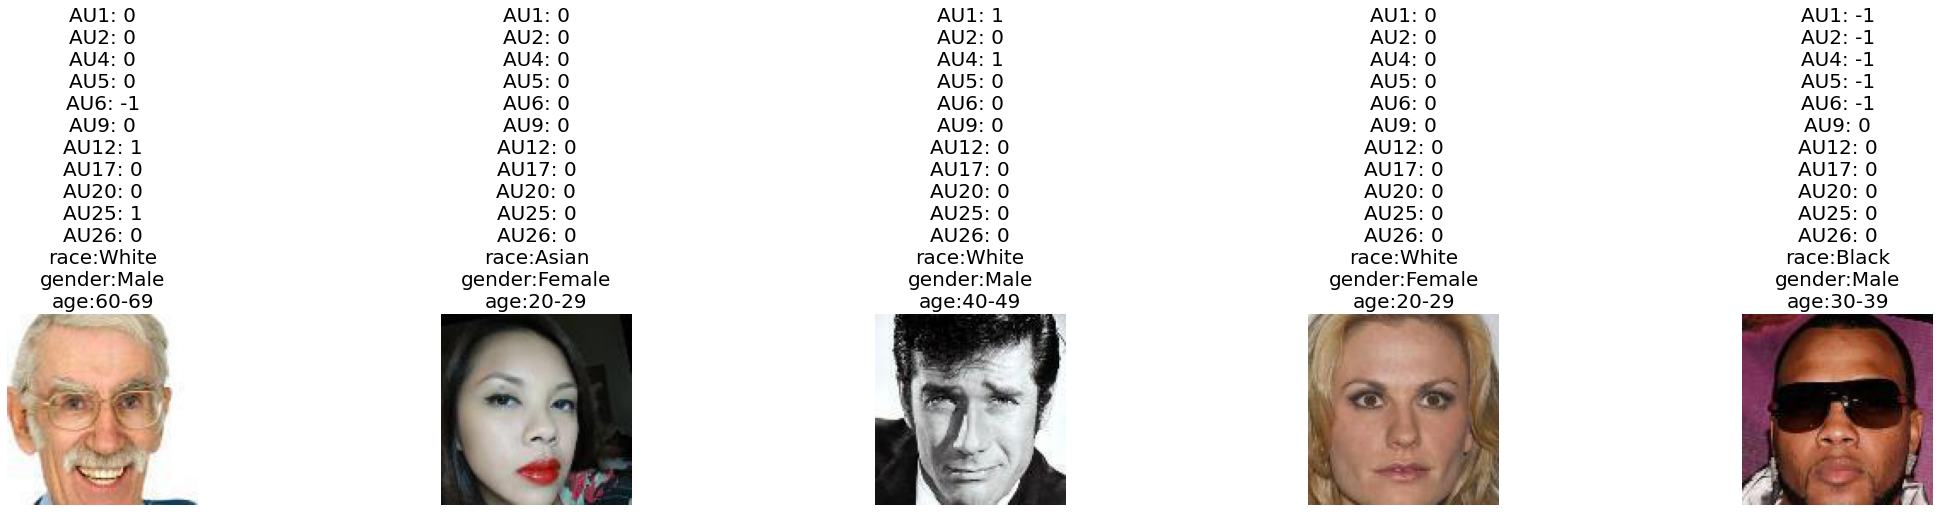

In [ ]:
num_images = 5
fig, axs = plt.subplots(figsize=(30, 7), ncols=num_images, constrained_layout=True)
for i in range(num_images):
  index = i+30
  image  =  mpimg.imread(df_train_fair['face_name_align'][index])
  axs[i].imshow(image)  
  axs[i].set_title('AU1: {}\nAU2: {}\nAU4: {}\nAU5: {}\nAU6: {}\nAU9: {}\nAU12: {}\nAU17: {}\nAU20: {}\nAU25: {}\nAU26: {}\nrace:{}\ngender:{}\nage:{}'.format(
      df_train_fair[1][index],df_train_fair[2][index],df_train_fair[3][index],df_train_fair[4][index],df_train_fair[5][index],df_train_fair[6][index],
      df_train_fair[7][index],df_train_fair[8][index],df_train_fair[9][index],df_train_fair[10][index],df_train_fair[11][index],
      df_train_fair['race'][index],df_train_fair['gender'][index],df_train_fair['age'][index]),fontsize = 20)
  axs[i].axis("off")

## data preprocessing 

In [ ]:
# load one image
image = Image.open(df_train_fair['face_name_align'][12332])
# convert image to numpy array
data = np.asarray(image)

In [ ]:
print(np.shape(data))

(112, 112, 3)


Οι εικόνες που στέλνουμε στο νευρωνικό δίκτυο είναι resized σε 112*112 και είναι έγχρωμες (τιμές απο 0-255). <br>
 Έτσι στο δίκτυο οι πίνακες είναι μεγέθους 112 * 112 * 3. 

In [ ]:
# get batches of tensor image data (rescaled to 0-1)
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
batch_size = 32

train_generator_fair = train_datagen.flow_from_dataframe(
    df_train_fair,
    x_col='face_name_align',
    y_col=[1,2,3,4,5,6,7,8,9,10,11],
    target_size=(112, 112),
    color_mode='rgb',
    class_mode='raw', #multilabel output numpy array of values in y_col column(s),
    batch_size=batch_size 
  )

validation_generator_fair = test_datagen.flow_from_dataframe(
    df_validation_fair,
    x_col="face_name_align",
    y_col=[1,2,3,4,5,6,7,8,9,10,11],
    target_size=(112, 112),
    color_mode='rgb',
    class_mode='raw',
    batch_size=batch_size
  )

test_generator_fair = test_datagen.flow_from_dataframe(
    df_test_fair,
    x_col="face_name_align",
    y_col=[1,2,3,4,5,6,7,8,9,10,11],
    target_size=(112, 112),
    color_mode='rgb',
    class_mode='raw',
    batch_size=batch_size,
    shuffle=False
  )


Found 24672 validated image filenames.
Found 6688 validated image filenames.
Found 13549 validated image filenames.


## Class distribution

In [ ]:
print("Actiavated AU ratio for all sets after split")
data = []
ratio_train = []
ratio_val = []
ratio_test = []
aus = []
tt_diff = []
tv_diff = []
for au in range(1,12):  
  aus.append(au)   
  r_train = len(df_train_fair[df_train_fair[au]==1])/(len(df_train_fair)-len(df_train_fair[df_train_fair[au]==-1]))
  r_val = len(df_validation_fair[df_validation_fair[au]==1])/(len(df_validation_fair)-len(df_validation_fair[df_validation_fair[au]==-1]))
  r_test = len(df_test_fair[df_test_fair[au]==1])/(len(df_test_fair)-len(df_test_fair[df_test_fair[au]==-1]))
  ratio_train.append(r_train)
  ratio_val.append(r_val)
  ratio_test.append(r_test)

  tt_diff.append(np.round(np.sum(np.square(r_train - r_test)),4))
  tv_diff.append(np.round(np.sum(np.square(r_train - r_val)),4))

table = zip(aus,ratio_train, ratio_val,ratio_test,tt_diff,tv_diff)
print(tabulate(table, headers=['AUs','train ratio','validation ratio','test ratio','train-test distance','train-val distance'], floatfmt=".4f"))

Actiavated AU ratio for all sets after split
  AUs    train ratio    validation ratio    test ratio    train-test distance    train-val distance
-----  -------------  ------------------  ------------  ---------------------  --------------------
    1         0.0616              0.0834        0.0499                 0.0001                0.0005
    2         0.0299              0.0591        0.0348                 0.0000                0.0009
    3         0.1152              0.0723        0.0813                 0.0012                0.0018
    4         0.0369              0.0620        0.0668                 0.0009                0.0006
    5         0.2002              0.2717        0.2181                 0.0003                0.0051
    6         0.0197              0.0166        0.0051                 0.0002                0.0000
    7         0.3859              0.4039        0.3932                 0.0001                0.0003
    8         0.0203              0.0157        0.0080 

In [ ]:
def plot_samples(category,names,train_counter,val_counter,test_counter):
  fig, axs = plt.subplots(figsize=(20, 4), ncols=3, constrained_layout=True)
  sets = ['train','validation','test']
  for i,set_counter in enumerate([train_counter,val_counter,test_counter]):
    names_list = [name for name in names]
    axs[i].bar(names_list,set_counter,color='c',  edgecolor='black')
    axs[i].set_title("{} distribution for {} set".format(category,sets[i]),fontsize=15)

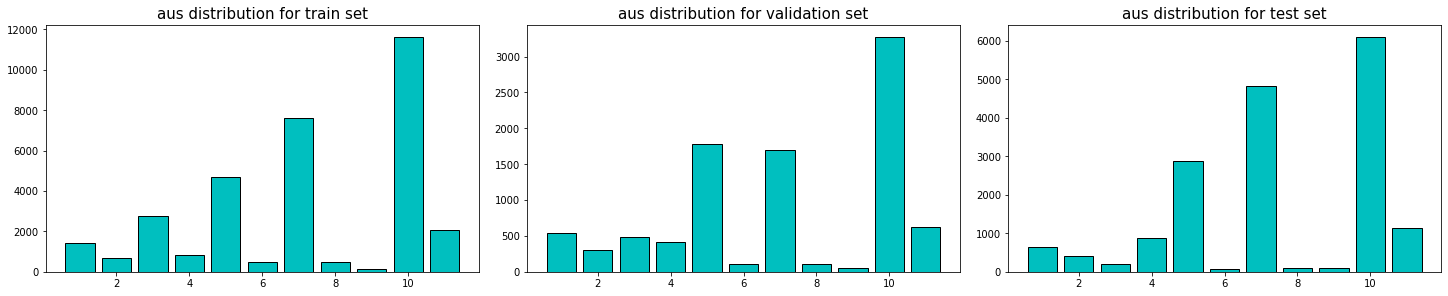

In [ ]:
final_aus = [i for i in range(1,12)]

aus_count_train = []
for i in final_aus:
  aus_count_train.append(len(df_train_fair[df_train_fair[i]==1]))

aus_count_val = []
for i in final_aus:
  aus_count_val.append(len(df_validation_fair[df_validation_fair[i]==1]))

aus_count_test = []
for i in final_aus:
  aus_count_test.append(len(df_test_fair[df_test_fair[i]==1]))

plot_samples('aus',final_aus,aus_count_train,aus_count_val,aus_count_test)


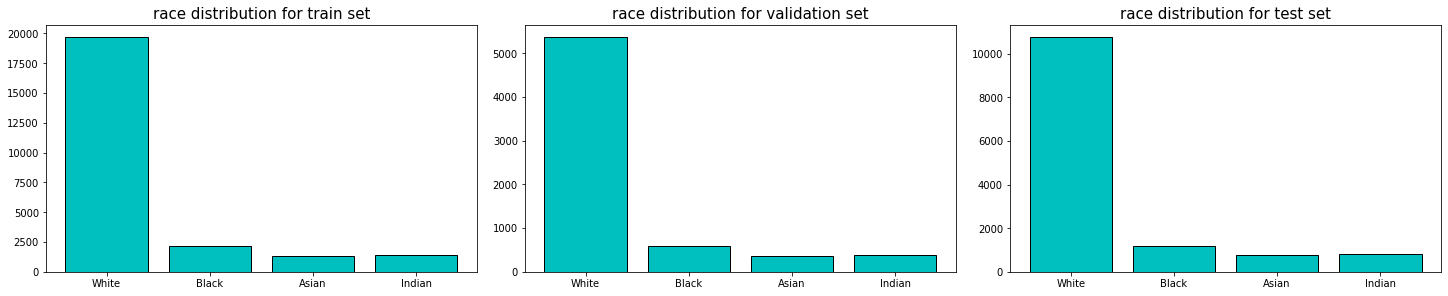

In [ ]:
race_names = ['White','Black','Asian','Indian']

race_counter_train = []
for i in range(len(race_names)):
  race_counter_train.append(len(df_train_fair[df_train_fair['race']==race_names[i]]))

race_counter_val = []
for i in range(len(race_names)):
  race_counter_val.append(len(df_validation_fair[df_validation_fair['race']==race_names[i]]))

race_counter_test = []
for i in range(len(race_names)):
  race_counter_test.append(len(df_test_fair[df_test_fair['race']==race_names[i]]))

plot_samples('race',race_names,race_counter_train,race_counter_val,race_counter_test)


In [ ]:
print(race_counter_train)
print(race_counter_val)
print(race_counter_test)

[19740, 2144, 1340, 1450]
[5379, 579, 359, 388]
[10790, 1191, 754, 814]


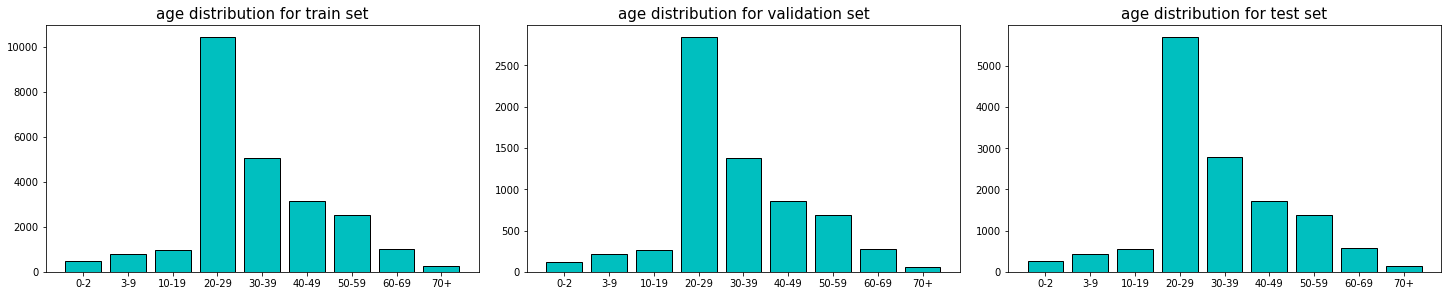

In [ ]:
age_names = ['0-2','3-9','10-19','20-29','30-39','40-49','50-59','60-69','70+']

age_counter_train = []
for i in range(len(age_names)):
  age_counter_train.append(len(df_train_fair[df_train_fair['age']==age_names[i]]))

age_counter_val = []
for i in range(len(age_names)):
  age_counter_val.append(len(df_validation_fair[df_validation_fair['age']==age_names[i]]))

age_counter_test = []
for i in range(len(age_names)):
  age_counter_test.append(len(df_test_fair[df_test_fair['age']==age_names[i]]))

plot_samples('age',age_names,age_counter_train,age_counter_val,age_counter_test)


In [ ]:
print(age_counter_train)
print(age_counter_val)
print(age_counter_test)

[460, 782, 986, 10454, 5075, 3136, 2513, 1026, 242]
[123, 210, 266, 2849, 1380, 852, 683, 278, 64]
[262, 435, 549, 5710, 2777, 1721, 1381, 571, 143]


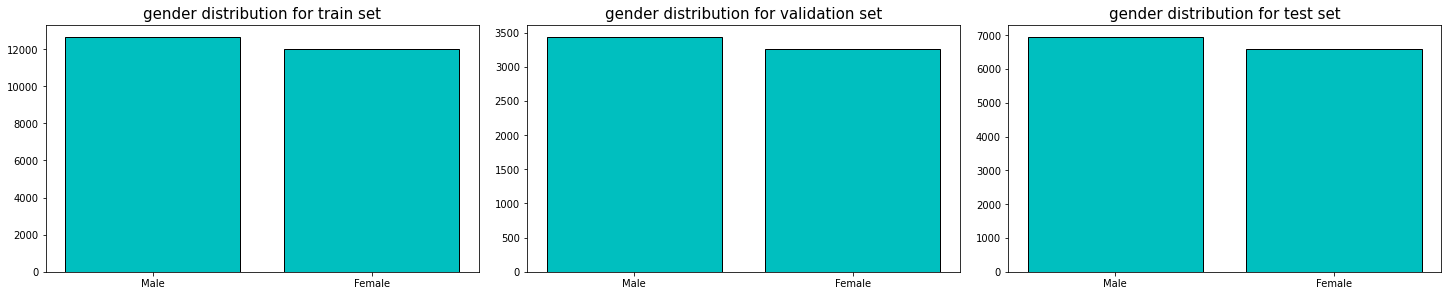

In [ ]:
gender_names = ['Male','Female']

gender_counter_train = []
for i in range(len(gender_names)):
  gender_counter_train.append(len(df_train_fair[df_train_fair['gender']==gender_names[i]]))

gender_counter_val = []
gender_names =  ['Male','Female']
for i in range(len(gender_names)):
  gender_counter_val.append(len(df_validation_fair[df_validation_fair['gender']==gender_names[i]]))

gender_counter_test = []
gender_names =  ['Male','Female']
for i in range(len(gender_names)):
  gender_counter_test.append(len(df_test_fair[df_test_fair['gender']==gender_names[i]]))

plot_samples('gender',gender_names,gender_counter_train,gender_counter_val,gender_counter_test)


In [ ]:
print(gender_counter_train)
print(gender_counter_val)
print(gender_counter_test)

[12678, 11996]
[3444, 3261]
[6958, 6591]


## training

Multilabel binary classification problem <br>
 

Οι επισημάνσεις για κάθε action unit μπορούν να πάρουν 3 τιμές: <br>
 0: AU not activated<br>
 1: AU activated<br>
-1: Unknown<br>

Αν ένα action unit έχει label = -1 πρέπει να αγνοείται το label και το αντίστοιχο prediction στον υπολογισμό του loss.

In [ ]:
def custom_loss_function(y_true, y_pred):
  au_loss = 0.
  for i in range(batch_size):
    pr = y_pred[i]
    lb = tf.cast(y_true[i],tf.float32)
    con = tf.greater(lb,-0.5)
    label_keep = tf.cast(tf.boolean_mask(lb,con),tf.float32)
    pr_keep = tf.boolean_mask(pr,con)
    #tf.print(pr_keep)
    au_loss +=  tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=label_keep,logits=pr_keep))/batch_size
  return(au_loss)

In [ ]:
#our model
resnet_model_fair = Sequential()

#pretrained model
pretrained_model= tf.keras.applications.ResNet50(
    include_top=False, #custume input and output layers based on our data
    weights="imagenet", #use weights from imagenet training 
    input_tensor=None,
    input_shape=(112,112,3),
    pooling='avg' , #average
)
     
resnet_model_fair.add(pretrained_model)

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
# see layers of resnet 50
#pretrained_model.summary()

In [ ]:
#resnet_model_fair.add(Dense(512, activation='relu'))
#resnet_model_fair.add(Dropout(0.2))
#resnet_model_fair.add(Dense(512, activation='relu'))
resnet_model_fair.add(Dense(11, activation='sigmoid'))


In [ ]:
resnet_model_fair.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 11)                22539     
                                                                 
Total params: 23,610,251
Trainable params: 23,557,131
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
#compile model
resnet_model_fair.compile(optimizer=Adam(learning_rate=0.0001),
                     loss= custom_loss_function)
#fit model


In [ ]:
#checkpoint 
filepath = "/content/gdrive/MyDrive/train_net/ckp_models/EmotioNet/Emotionet_simple_lr4_NO/EmotioNet_after/EmotioNet-{epoch:02d}.h5"
checkpoint = ModelCheckpoint(  
    filepath,
    monitor="val_loss",
    verbose=1,
    save_best_only=False,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch")

callbacks_list = [checkpoint]


#fit model
history = resnet_model_fair.fit(train_generator_fair,validation_data=validation_generator_fair,epochs=10,callbacks=callbacks_list)


Epoch 1/10
771/771 [==============================] - ETA: 0s - loss: 0.6767
Epoch 1: saving model to /content/gdrive/MyDrive/train_net/ckp_models/EmotioNet/Emotionet_simple_lr4_NO/EmotioNet_after/EmotioNet-01.h5
771/771 [==============================] - 132s 146ms/step - loss: 0.6767 - val_loss: 0.6730
Epoch 2/10
771/771 [==============================] - ETA: 0s - loss: 0.6698
Epoch 2: saving model to /content/gdrive/MyDrive/train_net/ckp_models/EmotioNet/Emotionet_simple_lr4_NO/EmotioNet_after/EmotioNet-02.h5
771/771 [==============================] - 106s 138ms/step - loss: 0.6698 - val_loss: 0.6664
Epoch 3/10
771/771 [==============================] - ETA: 0s - loss: 0.6692
Epoch 3: saving model to /content/gdrive/MyDrive/train_net/ckp_models/EmotioNet/Emotionet_simple_lr4_NO/EmotioNet_after/EmotioNet-03.h5
771/771 [==============================] - 105s 136ms/step - loss: 0.6692 - val_loss: 0.6665
Epoch 4/10
771/771 [==============================] - ETA: 0s - loss: 0.6687
Epoch

## evaluation & threshold
 

In [ ]:
models_labels_fair = {}
models_predictions_fair = {}
models_directory_fair = '/content/gdrive/MyDrive/train_net/ckp_models/EmotioNet/Emotionet_simple_lr4_NO/EmotioNet_after'
for saved_model in (os.listdir(models_directory_fair)):
  print(saved_model)
  model = tf.keras.models.load_model(os.path.join(models_directory_fair,saved_model),custom_objects={'custom_loss_function':custom_loss_function})
  models_labels_fair[saved_model[:-3]] = test_generator_fair.labels
  models_predictions_fair[saved_model[:-3]] = model.predict(test_generator_fair)


EmotioNet-01.h5
EmotioNet-02.h5
EmotioNet-03.h5
EmotioNet-04.h5
EmotioNet-05.h5
EmotioNet-06.h5
EmotioNet-07.h5
EmotioNet-08.h5
EmotioNet-09.h5
EmotioNet-10.h5


In [ ]:
print("now see results")

now see results


In [ ]:
for model_name in models_labels_fair.keys():
  aus_labels_fair,aus_predictions_fair = labels_predictions_aus(models_labels_fair[model_name],models_predictions_fair[model_name])
  print("Model Name: =",model_name)
  for thr in np.arange(0,1.1,0.1):
    mean_f1 = mean_macro_f1(aus_labels_fair,aus_predictions_fair,thr)
    print(" Threshold: {} F1 score: {}".format(np.round(thr,2),np.round(mean_f1,4)))


Model Name: = EmotioNet-01
 Threshold: 0.0 F1 score: 0.1991
 Threshold: 0.1 F1 score: 0.1906
 Threshold: 0.2 F1 score: 0.1891
 Threshold: 0.3 F1 score: 0.1883
 Threshold: 0.4 F1 score: 0.1874
 Threshold: 0.5 F1 score: 0.1868
 Threshold: 0.6 F1 score: 0.1861
 Threshold: 0.7 F1 score: 0.1854
 Threshold: 0.8 F1 score: 0.1843
 Threshold: 0.9 F1 score: 0.1826
 Threshold: 1.0 F1 score: 0.0757
Model Name: = EmotioNet-02
 Threshold: 0.0 F1 score: 0.1991
 Threshold: 0.1 F1 score: 0.2269
 Threshold: 0.2 F1 score: 0.2264
 Threshold: 0.3 F1 score: 0.2259
 Threshold: 0.4 F1 score: 0.2256
 Threshold: 0.5 F1 score: 0.2251
 Threshold: 0.6 F1 score: 0.2248
 Threshold: 0.7 F1 score: 0.2243
 Threshold: 0.8 F1 score: 0.2236
 Threshold: 0.9 F1 score: 0.2226
 Threshold: 1.0 F1 score: 0.16
Model Name: = EmotioNet-03
 Threshold: 0.0 F1 score: 0.1991
 Threshold: 0.1 F1 score: 0.2334
 Threshold: 0.2 F1 score: 0.2332
 Threshold: 0.3 F1 score: 0.233
 Threshold: 0.4 F1 score: 0.2329
 Threshold: 0.5 F1 score: 0.232

In [ ]:
best_model_name_fair = 'EmotioNet-08'
best_model_fair = tf.keras.models.load_model(os.path.join(models_directory_fair,"{}.h5".format(best_model_name_fair)),custom_objects={'custom_loss_function':custom_loss_function})
best_threshold_fair = 0.1

In [ ]:
# labels&predictions for each category
RACES =['White','Black','Asian','Indian']
y_true_race_fair,y_pred_race_fair,counter_race_fair = labels_predictions__category(df_test_fair,test_generator_fair,
                                                                 models_labels_fair[best_model_name_fair],models_predictions_fair[best_model_name_fair],
                                                                 RACES,'race')

GENDERS = ['Male','Female']
y_true_gender_fair,y_pred_gender_fair,counter_gender_fair = labels_predictions__category(df_test_fair,test_generator_fair,
                                                           models_labels_fair[best_model_name_fair],models_predictions_fair[best_model_name_fair],
                                                           GENDERS,'gender')

AGES = ['0-2','3-9','10-19','20-29','30-39','40-49','50-59','60-69','70+']
y_true_age_fair,y_pred_age_fair,counter_age_fair = labels_predictions__category(df_test_fair,test_generator_fair,
                                                     models_labels_fair[best_model_name_fair],models_predictions_fair[best_model_name_fair],
                                                     AGES,'age')



In [ ]:
import warnings
warnings.filterwarnings("ignore") 

In [ ]:
print("EmotioNet")
print("NO aug")
print("AFTER split")
aus_labels_best_fair, aus_predictions_best_fair = labels_predictions_aus(models_labels_fair[best_model_name_fair],models_predictions_fair[best_model_name_fair])
data = [[mean_macro_f1(aus_labels_best_fair,aus_predictions_best_fair,best_threshold_fair)]]
print(tabulate(data, headers=[" macro f1 score"]))
print()
results_category('after',RACES,'race',y_true_race_fair,y_pred_race_fair,best_threshold_fair,counter_race_fair)
results_category('after',GENDERS,'gender',y_true_gender_fair,y_pred_gender_fair,best_threshold_fair,counter_gender_fair)
results_category('after',AGES,'age',y_true_age_fair,y_pred_age_fair,best_threshold_fair,counter_age_fair)


EmotioNet
NO aug
AFTER split
   macro f1 score
-----------------
         0.236589

race scores after split
race      #images    mean binary f1 score
------  ---------  ----------------------
White       10790                0.237456
Black        1191                0.238609
Asian         754                0.227795
Indian        814                0.228116

gender scores after split
gender      #images    mean binary f1 score
--------  ---------  ----------------------
Male           6958                0.232518
Female         6591                0.239695

age scores after split
age      #images    mean binary f1 score
-----  ---------  ----------------------
0-2          262                0.199192
3-9          435                0.238303
10-19        549                0.229941
20-29       5710                0.23465
30-39       2777                0.241116
40-49       1721                0.240205
50-59       1381                0.23701
60-69        571                0.231122
70+  

## Visualize predictions

In [ ]:
print("Labels and Predictions for one batch")
X,y = test_generator_fair.next()
prediction_show_fair = best_model_fair.predict(X)
for i in range(batch_size):
  print("truth:      {}\nprediction: {} ".format(y[i],np.array(threshold_predictions(prediction_show_fair[i],best_threshold_fair))))


Labels and Predictions for one batch
truth:      [0 0 0 0 0 0 0 0 0 1 0]
prediction: [0 0 0 0 0 0 0 0 0 0 0] 
truth:      [-1 -1  0  0  0  0 -1 -1  0  1 -1]
prediction: [0 0 0 0 0 0 0 0 0 1 0] 
truth:      [ 0  1  0  0  0  0 -1  0  0  0  0]
prediction: [0 0 0 0 0 0 0 0 0 1 0] 
truth:      [ 1  0  0 -1  0 -1 -1 -1  0  0  0]
prediction: [0 0 0 0 0 0 0 0 0 0 0] 
truth:      [ 0 -1 -1 -1 -1 -1 -1  0  0 -1  0]
prediction: [0 0 0 0 0 0 0 0 0 1 0] 
truth:      [0 0 1 0 0 0 0 0 0 1 0]
prediction: [0 0 0 0 0 0 0 0 0 1 0] 
truth:      [0 0 0 0 0 0 0 0 0 1 0]
prediction: [0 0 0 0 0 0 0 0 0 1 0] 
truth:      [0 0 1 0 0 1 0 1 0 1 0]
prediction: [0 0 0 0 0 0 0 0 0 1 0] 
truth:      [0 0 0 1 0 0 0 0 0 0 0]
prediction: [0 0 0 0 0 0 0 0 0 0 0] 
truth:      [0 0 0 0 0 0 0 0 0 0 0]
prediction: [0 0 0 0 0 0 0 0 0 0 0] 
truth:      [ 0 -1  1  0  0  0 -1  0  0  1  0]
prediction: [0 0 0 0 0 0 0 0 0 0 0] 
truth:      [ 0  0  0  0  0  0 -1 -1  0 -1 -1]
prediction: [0 0 0 0 0 0 0 0 0 0 0] 
truth:      [ 0  0  1

# Results

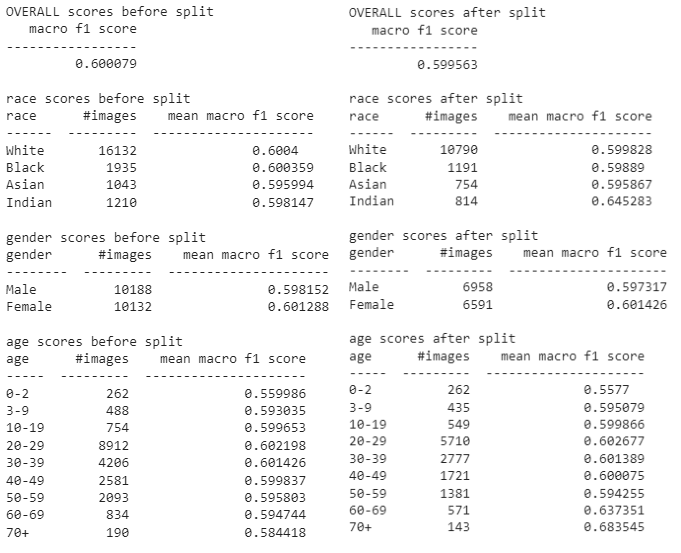

ΠΑΡΑΤΗΡΗΣΕΙΣ: 
* Το ολικό αποτελέσμα πρίν και μετά το split είναι σχεδον το ίδιο
* Στις κατηγορίες RACE: indian και AGE: 70+ το f1 score είναι καλύτερο μετά το split. Για τις υπόλοιπες κατηγορίες το f1 score είναι περιπου το ίδιο
* Emotionet before: train&val only